# Quantum dataset - logistic

The objective value and the all gradient descents are saved in a pickle file. Thus, it is possible to play with results without need to recompute everything (it takes several hours). 
However, the transformed data is not saved because it can be generated without random. Thus to regenerate figures, be sure to intialy run the first cells of the notebook (those devoted to data preparation).

In [1]:
# Add below current directory to path
# Notebook cannot import any code without this line !!!!
import sys; sys.path.insert(0, '..')

import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import IntSlider, interact
from math import sqrt

from sklearn.preprocessing import scale

from tqdm import tqdm, trange # For progress bar
%matplotlib inline
%load_ext autoreload
%autoreload 2

from src.models.CostModel import LogisticModel, RMSEModel, build_several_cost_model

from src.machinery.GradientDescent import ArtemisDescent, SGD_Descent
from src.machinery.GradientUpdateMethod import ArtemisUpdate
from src.machinery.Parameters import *
from src.machinery.PredefinedParameters import *

from src.utils.ErrorPlotter import *
from src.utils.data.RealDatasetPreparation import prepare_quantum
from src.utils.Constants import *
from src.utils.data.DataClustering import *
from src.utils.data.DataPreparation import build_data_logistic, add_bias_term
from src.utils.Utilities import pickle_loader, pickle_saver
from src.utils.runner.RunnerUtilities import *
from src.utils.runner.ResultsOfSeveralDescents import ResultsOfSeveralDescents

filename = "quantum"

nb_devices_for_the_run = 20

## Handling IID data

In [10]:
def quantum_step_size(it, L, omega, N): return 1 / (8 * L)

In [11]:
%%time
X, Y, dim_notebook = prepare_quantum(nb_devices_for_the_run)

Following columns has missing values: [21, 22, 23, 30, 45, 46, 47, 56]
The columns with empty values have been removed.
This columns are empty: [40, 41, 42, 43, 44]
Now, there is 65 dimensions.
Head of the dataset (columns has not been re-indexed).
   state         2         3         4    5         6    7         8    9  \
0     -1  0.000000  0.000000  0.000000  0.0  0.000000  0.0  0.000000  0.0   
1     -1  0.920167  0.817883 -0.646473 -1.0  0.000000  0.0  0.000000  0.0   
2      1  0.868397  0.178202  0.150828 -1.0  0.000000  0.0  0.000000  0.0   
3     -1  0.000000  0.000000  0.000000  0.0  1.577894  0.0 -0.369792 -1.0   
4     -1  0.000000  0.000000  0.000000  0.0  0.000000  0.0  0.000000  0.0   

         10  ...   70        71        72        73        74        75   76  \
0  0.876238  ... -1.0 -0.036906 -0.000724  0.000000  0.000000  0.000000  0.0   
1  0.401383  ... -1.0 -0.999927 -0.012102  0.920167  0.817883 -0.646473 -1.0   
2  0.773496  ...  1.0  0.908824  0.550843  0.868

In [82]:
# Checking that data is balanced over devices.
print("Diplaying the ratio between state 1 and state -1.")
print("If data is iid, the ratio should be close to 0.5")
for y in Y:
    print("ratio of state 1 on this device: ", abs((y == 1).sum().item() / abs(y).sum().item()))

Diplaying the ratio between state 1 and state -1.
If data is iid, the ratio should be close to 0.5
ratio of state 1 on this device:  0.4808
ratio of state 1 on this device:  0.5092
ratio of state 1 on this device:  0.5064
ratio of state 1 on this device:  0.4744
ratio of state 1 on this device:  0.494
ratio of state 1 on this device:  0.5192
ratio of state 1 on this device:  0.4844
ratio of state 1 on this device:  0.494
ratio of state 1 on this device:  0.5236
ratio of state 1 on this device:  0.498
ratio of state 1 on this device:  0.4912
ratio of state 1 on this device:  0.4856
ratio of state 1 on this device:  0.4964
ratio of state 1 on this device:  0.5068
ratio of state 1 on this device:  0.5
ratio of state 1 on this device:  0.4924
ratio of state 1 on this device:  0.4936
ratio of state 1 on this device:  0.4928
ratio of state 1 on this device:  0.4916
ratio of state 1 on this device:  0.51


In [12]:
# Creating cost models which will be used to computed cost/loss, gradients, L ...
cost_models = build_several_cost_model(LogisticModel, X, Y, nb_devices_for_the_run)

In [87]:
%%time
obj_min_by_N_descent = SGD_Descent(Parameters(n_dimensions = dim_notebook + 1, 
                                                nb_devices=nb_devices_for_the_run,
                                                nb_epoch=5000, 
                                                momentum = 0., 
                                                verbose=True, 
                                                cost_models=cost_models,
                                                stochastic=False,
                                                bidirectional=False
                                               ))
obj_min_by_N_descent.run(cost_models)
obj_min = obj_min_by_N_descent.losses[-1]
pickle_saver(obj_min, filename + "-iid-obj_min")

   it    |   obj   
    1000 | 5.4297e-01
    2000 | 5.4297e-01
    3000 | 5.4297e-01
    4000 | 5.4297e-01
Gradient Descent: execution time=48.535 seconds
Final loss : 0.54297

CPU times: user 3min 12s, sys: 1.39 s, total: 3min 13s
Wall time: 48.5 s


In [88]:
def ratio_failure(index: int, guess: int = 1):
    x = X[index]
    y = Y[index]
    w = obj_min_by_N_descent.model_params[-1]
    mul =  x.mv(w)
    inf_middle = 0
    failure = 0
    for i in range(len(mul)):
        if guess == 1:
            if torch.sigmoid(mul[i]) >= 0.5:
                if y[i] != guess:
                    failure +=1
                inf_middle +=1
        else:
            if torch.sigmoid(mul[i]) < 0.5:
                if y[i] != guess:
                    failure +=1
                inf_middle +=1
    print("Number of labels equal to " + str(guess) + ": ", inf_middle)
    print("Failures:", failure)
    print("Percent of labels wrongly predicted to be state " + str(guess) +" for worker 0: " + 
          str(failure/inf_middle * 100) + "%")
    
ratio_failure(1, 1)
ratio_failure(0, 1)

Number of labels equal to 1:  1246
Failures: 356
Percent of labels wrongly predicted to be state 1 for worker 0: 28.57142857142857%
Number of labels equal to 1:  1238
Failures: 387
Percent of labels wrongly predicted to be state 1 for worker 0: 31.260096930533116%


In [13]:
%%time
all_descent = {}
for type_params in tqdm(KIND_COMPRESSION):
    multiple_sg_descent = multiple_run_descent(type_params, cost_models=cost_models,
                                               step_formula=quantum_step_size,
                                               nb_epoch=2,
                                               compression_model = SQuantization(1, dim_notebook+1),
                                               use_averaging=True, logs_file="{0}.txt".format(filename))
    all_descent[type_params.name()] = multiple_sg_descent
res = ResultsOfSeveralDescents(all_descent, nb_devices_for_the_run)
#pickle_saver(res, filename + "-iid-descent")

100%|██████████| 5/5 [02:46<00:00, 33.23s/it]

CPU times: user 2min 53s, sys: 159 ms, total: 2min 53s
Wall time: 2min 46s


In [16]:
print("Model obtain from Vanilla SGD descent, the first value corresponds to the bias: ")
print(res.all_final_model[0])

Model obtain from Vanilla SGD descent, the first value corresponds to the bias: 
tensor([-1.3494e-02, -6.8809e-03,  4.1352e-02, -4.2375e-02,  7.3730e-01,
         3.5704e-03, -1.0915e-02,  1.5517e-02,  2.5387e-01,  1.0405e-02,
         2.7300e-02,  1.9985e-03, -2.6709e-02,  1.0214e+00,  4.2038e-01,
         1.1981e-01, -2.1260e-02, -4.0603e-02,  1.5264e-03,  1.3468e-02,
        -1.7042e-02, -3.0125e-02,  2.1454e-02,  5.0315e-02, -2.1344e-02,
         6.7662e-02, -3.8299e-02, -1.1311e-01,  4.7663e-02, -4.9348e-02,
        -3.8202e-02,  3.2482e-02,  2.0050e-02,  3.7529e-02,  7.1673e-03,
        -5.1172e-03, -5.3779e-02,  2.0519e-02,  3.8129e-02,  1.0974e-02,
         1.3238e-02, -7.2326e-03, -4.7154e-02, -9.0619e-02, -7.0764e-02,
         7.1029e-02,  6.8190e-02, -2.0629e-02,  6.7808e-04, -5.4890e-03,
         1.4786e-01,  8.6216e-03, -7.4912e-03,  1.4010e-01, -7.5630e-03,
        -5.2972e-02, -1.0900e-01, -2.7347e-03,  3.1280e-01, -5.1700e-02,
         1.3226e-02,  1.4861e-02, -6.0715e-

### With averaging

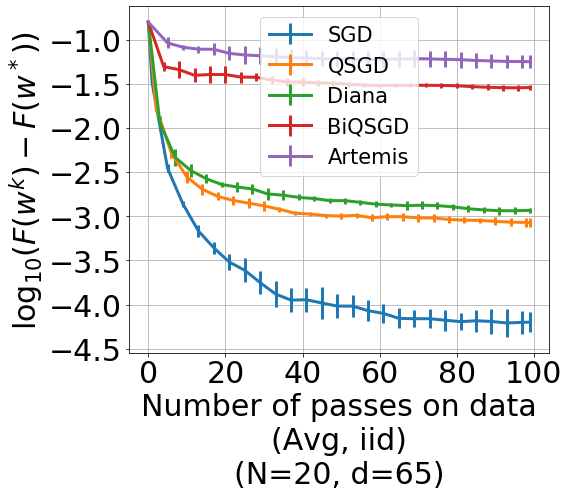

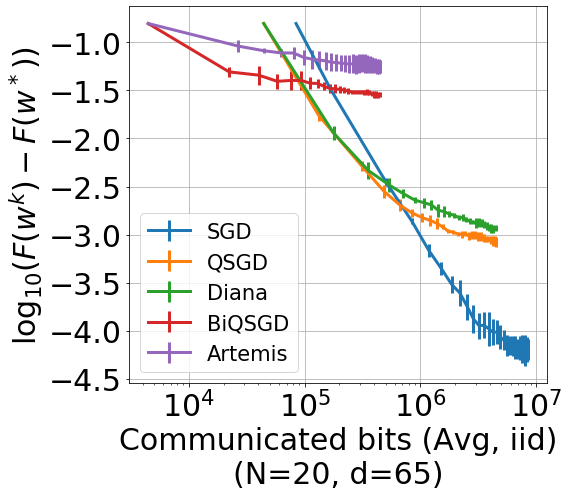

In [4]:
obj = pickle_loader(filename + "-iid-obj_min")
res = pickle_loader(filename + "-iid-descent")

plot_error_dist(res.get_loss(obj, averaged=True), res.names, res.nb_devices_for_the_run, 
                dim_notebook, all_error=res.get_std(obj, averaged=True), x_legend="Number of passes on data\n(Avg, iid)") 
plot_error_dist(res.get_loss(obj, averaged=True), res.names, res.nb_devices_for_the_run, dim_notebook, 
                x_points=res.X_number_of_bits, all_error=res.get_std(obj, averaged=True), 
                x_legend="Communicated bits (Avg, iid)") 


### Without averaging

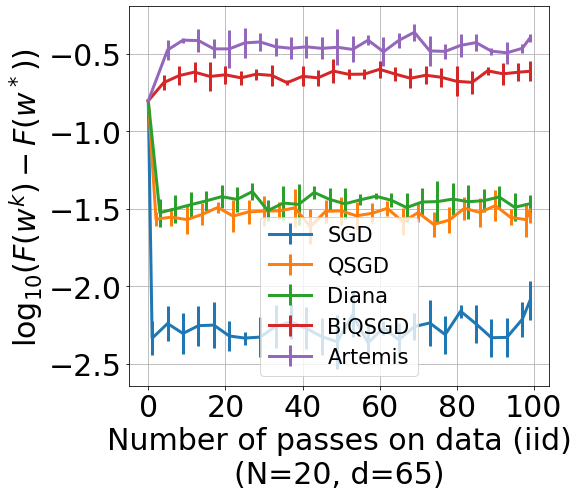

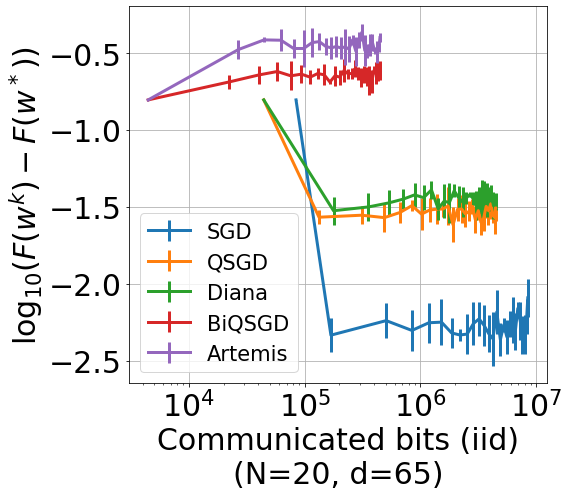

In [5]:
obj_min_by_N = pickle_loader(filename + "-iid-obj_min")
res = pickle_loader(filename + "-iid-descent")

plot_error_dist(res.get_loss(obj), res.names, res.nb_devices_for_the_run, dim_notebook,
                x_legend="Number of passes on data (iid)", all_error=res.get_std(obj)) 
plot_error_dist(res.get_loss(obj), res.names, res.nb_devices_for_the_run, dim_notebook, 
                x_points=res.X_number_of_bits, x_legend="Communicated bits (iid)", all_error=res.get_std(obj)) 

# Handling non-iid data

In [32]:
def quantum_step_size(it, L, omega, N): return 1 / (8*L)

Following columns has missing values: [21, 22, 23, 30, 45, 46, 47, 56]
The columns with empty values have been removed.
This columns are empty: [40, 41, 42, 43, 44]
Now, there is 65 dimensions.
Head of the dataset (columns has not been re-indexed).
   state         2         3         4    5         6    7         8    9  \
0     -1  0.000000  0.000000  0.000000  0.0  0.000000  0.0  0.000000  0.0   
1     -1  0.920167  0.817883 -0.646473 -1.0  0.000000  0.0  0.000000  0.0   
2      1  0.868397  0.178202  0.150828 -1.0  0.000000  0.0  0.000000  0.0   
3     -1  0.000000  0.000000  0.000000  0.0  1.577894  0.0 -0.369792 -1.0   
4     -1  0.000000  0.000000  0.000000  0.0  0.000000  0.0  0.000000  0.0   

         10  ...   70        71        72        73        74        75   76  \
0  0.876238  ... -1.0 -0.036906 -0.000724  0.000000  0.000000  0.000000  0.0   
1  0.401383  ... -1.0 -0.999927 -0.012102  0.920167  0.817883 -0.646473 -1.0   
2  0.773496  ...  1.0  0.908824  0.550843  0.868

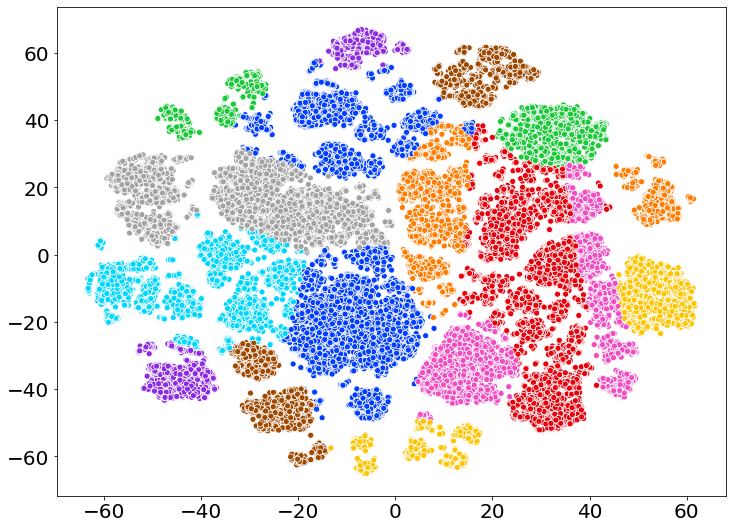

In [66]:
%%time
nb_cluster = nb_devices_for_the_run
X, Y, dim_notebook = prepare_quantum(nb_cluster, iid=False)

In [67]:
# Checking that data is unbalanced over devices.
print("Diplaying the ratio between state 1 and state -1.")
print("If data is iid, the ratio should be close to 0.5")
for y in Y:
    print("ratio of state 1 on this device: ", abs((y == 1).sum().item() / abs(y).sum().item()))

Diplaying the ratio between state 1 and state -1.
If data is iid, the ratio should be close to 0.5
ratio of state 1 on this device:  0.39624556062912225
ratio of state 1 on this device:  0.9188921859545005
ratio of state 1 on this device:  0.4898897058823529
ratio of state 1 on this device:  0.0012642225031605564
ratio of state 1 on this device:  0.24748646558391338
ratio of state 1 on this device:  0.48473748473748474
ratio of state 1 on this device:  0.4220643543669035
ratio of state 1 on this device:  0.540224032586558
ratio of state 1 on this device:  0.45410235580828595
ratio of state 1 on this device:  0.5100229095074456
ratio of state 1 on this device:  0.6459042135566606
ratio of state 1 on this device:  0.42004078065831635
ratio of state 1 on this device:  0.6226692836113837
ratio of state 1 on this device:  0.5859502632056635
ratio of state 1 on this device:  0.08495981630309989
ratio of state 1 on this device:  0.3948948948948949
ratio of state 1 on this device:  0.986651411

In [68]:
# Creating cost models which will be used to computed cost/loss, gradients, L ...
cost_models = build_several_cost_model(LogisticModel, X, Y, nb_devices_for_the_run)

In [69]:
%%time
obj_min_by_N_descent = SGD_Descent(Parameters(n_dimensions = dim_notebook + 1, 
                                                nb_devices=nb_cluster,
                                                nb_epoch=10000, 
                                                momentum = 0., 
                                                verbose=True, 
                                                cost_models=cost_models,
                                                stochastic=False,
                                                bidirectional=False
                                                ))
obj_min_by_N_descent.run(cost_models)
obj_min = obj_min_by_N_descent.losses[-1]
pickle_saver(obj_min, filename + "-noniid-obj_min")

   it    |   obj   
    2000 | 5.2482e-01
    4000 | 5.2482e-01
    6000 | 5.2482e-01
    8000 | 5.2482e-01
Gradient Descent: execution time=93.495 seconds
Final loss : 0.52482

CPU times: user 6min 11s, sys: 2.09 s, total: 6min 13s
Wall time: 1min 33s


## Batch size $= 1$ (stochastic)

In [16]:
%%time
all_descent = {}
for type_params in tqdm(KIND_COMPRESSION):
    multiple_sg_descent = multiple_run_descent(type_params, cost_models=cost_models,
                                               use_averaging=True, nb_epoch=2,
                                               compression_model = SQuantization(1, dim_notebook+1),
                                               step_formula=quantum_step_size,
                                               logs_file="{0}.txt".format(filename))
    all_descent[type_params.name()] = multiple_sg_descent
#pickle_saver(res, filename + "-noniid-descent")

100%|██████████| 5/5 [02:54<00:00, 34.99s/it]

CPU times: user 3min 2s, sys: 140 ms, total: 3min 2s
Wall time: 2min 54s


### With averaging

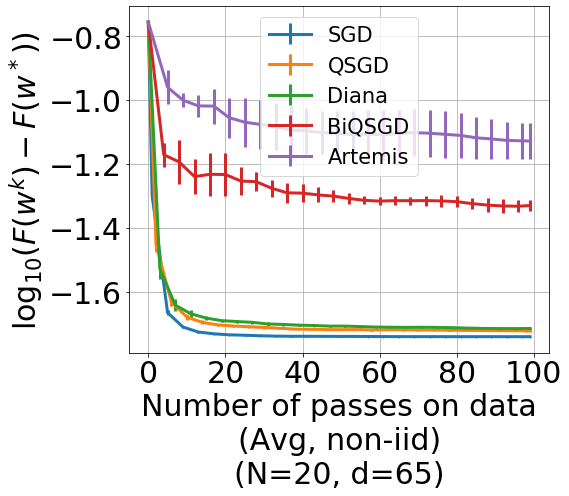

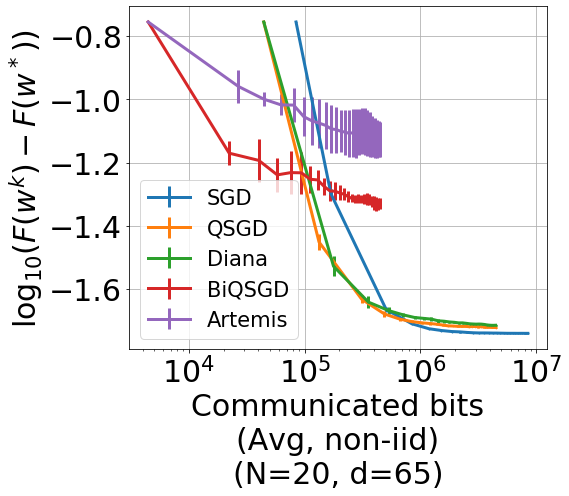

In [7]:
obj = pickle_loader(filename + "-noniid-obj_min")
res = pickle_loader(filename + "-noniid-descent")

plot_error_dist(res.get_loss(obj, averaged=True), res.names, res.nb_devices_for_the_run, dim_notebook, 
                all_error=res.get_std(obj, averaged=True), 
                x_legend="Number of passes on data\n(Avg, non-iid)") 

plot_error_dist(res.get_loss(obj, averaged=True), res.names, res.nb_devices_for_the_run, dim_notebook,
                x_points=res.X_number_of_bits, 
                x_legend="Communicated bits\n(Avg, non-iid)", all_error=res.get_std(obj, averaged=True)) 

### Without averaging

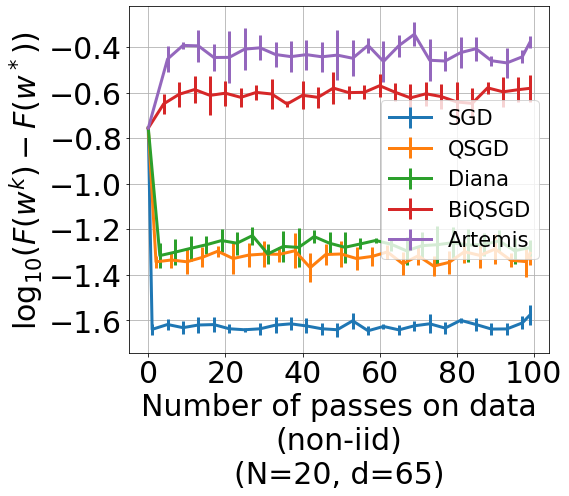

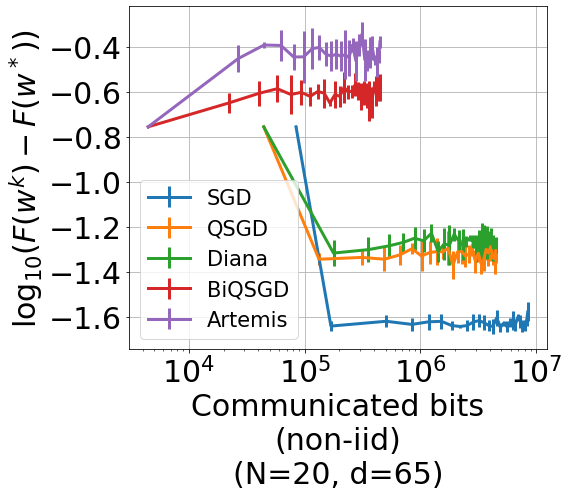

In [8]:
# TEMPORARY - Because the new clusters are different from the ones used to generate the figures.
obj = pickle_loader(filename + "-noniid-obj_min")
res = pickle_loader(filename + "-noniid-descent")

plot_error_dist(res.get_loss(obj), res.names, res.nb_devices_for_the_run, dim_notebook,
               all_error=res.get_std(obj), x_legend="Number of passes on data\n(non-iid)") 

plot_error_dist(res.get_loss(obj), res.names, res.nb_devices_for_the_run, dim_notebook,
                x_points=res.X_number_of_bits, 
                x_legend="Communicated bits\n(non-iid)", all_error=res.get_std(obj)) 

## Batch size $= 400$

In [61]:
def quantum_step_formula(it, L, omega, N): return 1 / (L)

In [74]:
%%time
batch_size = 400
all_descent = {}
for type_params in tqdm(KIND_COMPRESSION):
    multiple_sg_descent = multiple_run_descent(type_params, cost_models=cost_models, 
                                               compression_model = SQuantization(1, dim_notebook+1),
                                               step_formula=quantum_step_formula,
                                               use_averaging=False, stochastic=True, batch_size=batch_size, 
                                               nb_epoch=300, logs_file="{0}.txt".format(filename))
    all_descent[type_params.name()] = multiple_sg_descent
res = ResultsOfSeveralDescents(all_descent, len(X))
pickle_saver(res, "{0}-noniid-descent-{1}".format(filename, batch_size))

100%|██████████| 5/5 [05:28<00:00, 65.66s/it]

CPU times: user 21min 41s, sys: 10.4 s, total: 21min 52s
Wall time: 5min 28s


### Without averaging

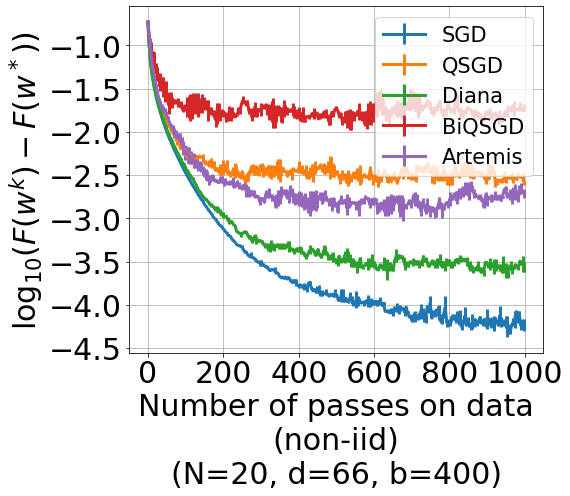

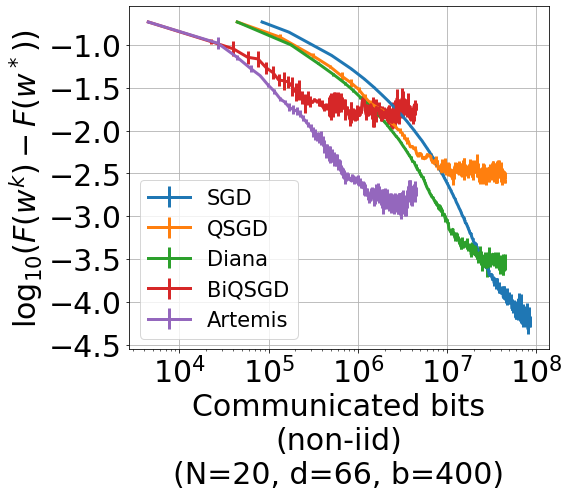

In [12]:
obj = pickle_loader(filename + "-noniid-obj_min")
res = pickle_loader("{0}-noniid-descent-{1}".format(filename, batch_size))

plot_error_dist(res.get_loss(obj), res.names, res.nb_devices_for_the_run, dim_notebook, batch_size=batch_size,
               all_error=res.get_std(obj), x_legend="Number of passes on data\n(non-iid)") 

plot_error_dist(res.get_loss(obj), res.names, res.nb_devices_for_the_run, dim_notebook,
                x_points=res.X_number_of_bits,  batch_size=batch_size,
                x_legend="Communicated bits\n(non-iid)", all_error=res.get_std(obj)) 

### With averaging

In [9]:
batch_size = 400
obj = pickle_loader(filename + "-noniid-obj_min")
res = pickle_loader("{0}-noniid-descent-{1}".format(filename, batch_size))

plot_error_dist(res.get_loss(obj, averaged=True), res.names, res.nb_devices_for_the_run, dim_notebook, 
                all_error=res.get_std(obj, averaged=True), batch_size=batch_size,
                x_legend="Number of passes on data\n(Avg, non-iid)") 

plot_error_dist(res.get_loss(obj, averaged=True), res.names, res.nb_devices_for_the_run, dim_notebook,
                x_points=res.X_number_of_bits,  batch_size=batch_size,
                x_legend="Communicated bits\n(Avg, non-iid)", all_error=res.get_std(obj, averaged=True)) 

IndexError: index 0 is out of bounds for axis 0 with size 0

<Figure size 576x504 with 0 Axes>